# Pipeline Notebook 

## Imports

In [6]:
import handwriting
import keras
import tensorflow as tf
import preprocess

## Bounding Box

### Bounding Box Modell

## Show Image Real Image

In [47]:
from bounding_box.model import load_weight_model,predict_image,get_image_as_array, show_image 
from bounding_box.config import NUM_CLASSES_ALL,BBOX_PATH,MAIN_BBOX_DETECTOR_MODEL,SUB_BBOX_DETECTOR_MODEL  
from bounding_box.model import load_weight_model, predict_image,plot_image, get_templated_data, edit_sub_boxes_cut_links, edit_sub_boxes_cut_top
from bounding_box.template import build_templating_data

bbox_model = load_weight_model(r"C:\Users\timBo\Desktop\Python Projects\SmartApp-Project\bounding_box\workspace\models\main_bbox_detector_model.h5",4)
image_path = "../bounding_box/workspace/images/test_images/image_0001.jpg"
boxes, confidence, classes = predict_image(image_path, bbox_model)

1/1 [==============================] - 5s 5s/step


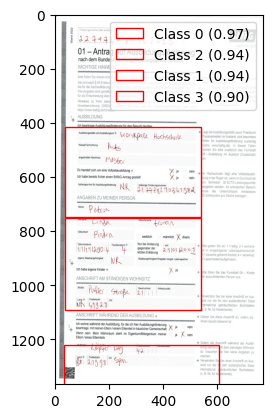

In [48]:
show_image((image_path), boxes,confidence,classes )  

## Templating

1/1 [==============================] - 5s 5s/step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

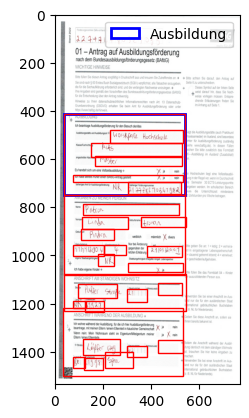

In [49]:
# inter the path of the model
bbox_model = load_weight_model(r"C:\Users\timBo\Desktop\Python Projects\SmartApp-Project\bounding_box\workspace\models\main_bbox_detector_model.h5",4)
main_boxes, confidence, classes = predict_image(image_path, bbox_model)
org_ms_boxes_person, org_ms_boxes_wohnsitz, org_ms_boxes_ausbildung, org_ms_boxes_wwa, person_class_ids, ausbildung_class_ids, wohnsitz_class_ids, wwa_class_ids, widthOrgImag, heightOrgImag = build_templating_data()

ausbildung, person, wohnsitz, wwa, best_predicted = get_templated_data(main_boxes, confidence, classes, org_ms_boxes_person,
                                                                       org_ms_boxes_wohnsitz, org_ms_boxes_ausbildung,
                                                                       org_ms_boxes_wwa, person_class_ids,
                                                                       ausbildung_class_ids, wohnsitz_class_ids,
                                                                       wwa_class_ids)


top_cut = False
if top_cut:
    ausbildung_cut_top, person_cut_top, wohnsitz_cut_top, wwa_cut_top = edit_sub_boxes_cut_top(ausbildung, person, wohnsitz, wwa)
    sub_boxes = ausbildung_cut_top[0] + person_cut_top[0] +  wohnsitz_cut_top[0] +  wwa_cut_top[0] 
    plot_image((image_path), ausbildung_cut_top, person_cut_top, wohnsitz_cut_top, wwa_cut_top, best_predicted)
else:
    ausbildung_cut_links, person_cut_links, wohnsitz_cut_links, wwa_cut_links = edit_sub_boxes_cut_links(ausbildung, person, wohnsitz, wwa)
    sub_boxes = ausbildung_cut_links[0]  + person_cut_links[0]  + wohnsitz_cut_links[0]  + wwa_cut_links[0] 
    plot_image(image_path, ausbildung_cut_links, person_cut_links, wohnsitz_cut_links, wwa_cut_links, best_predicted)


In [50]:
print(len(sub_boxes))

29


### ROI Crop

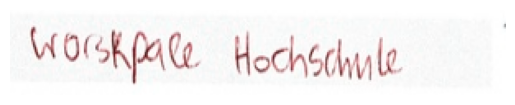

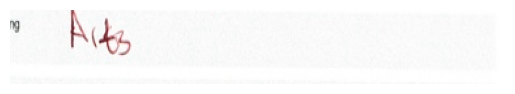

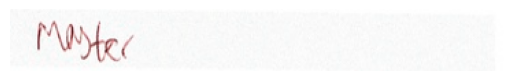

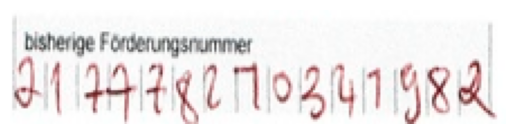

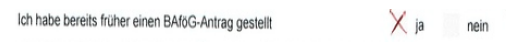

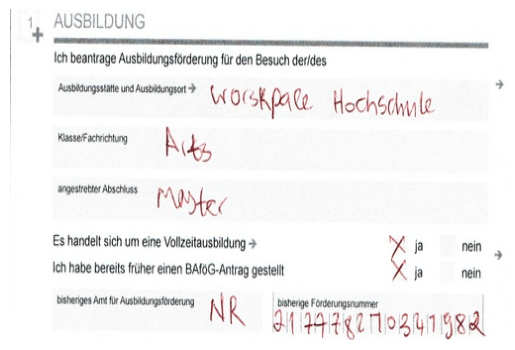

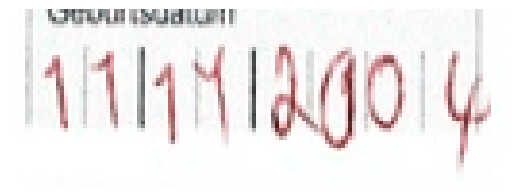

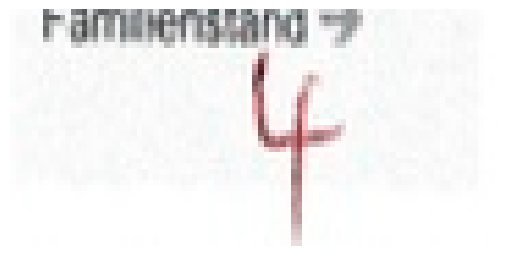

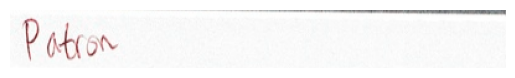

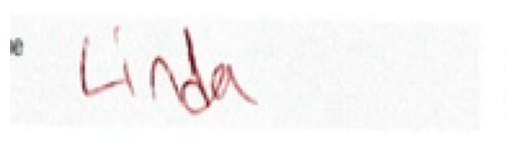

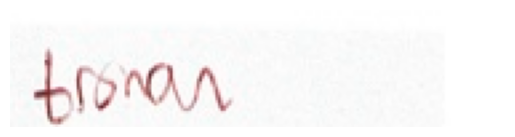

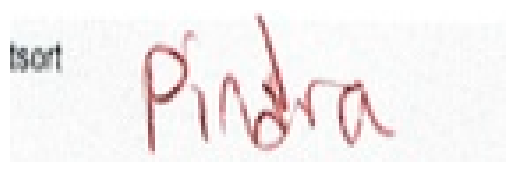

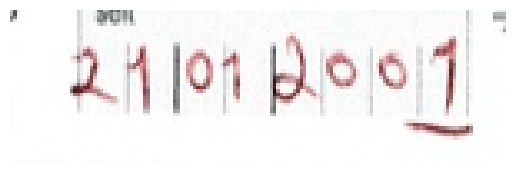

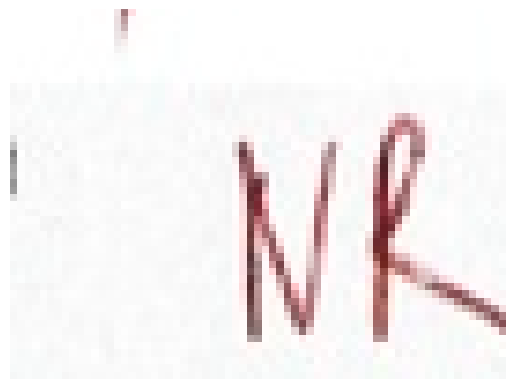

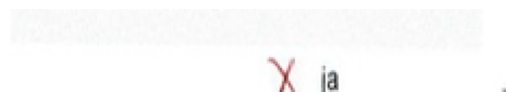

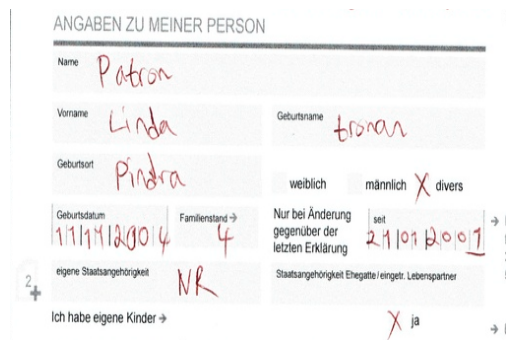

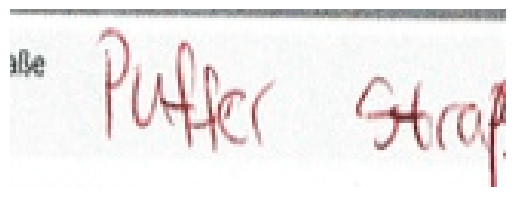

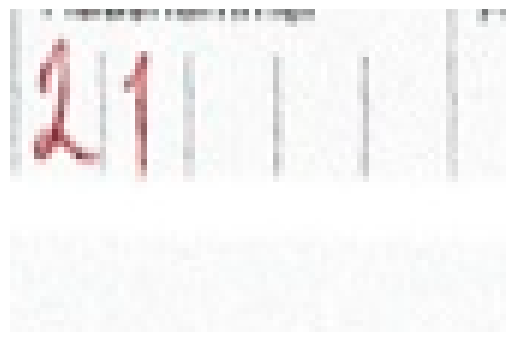

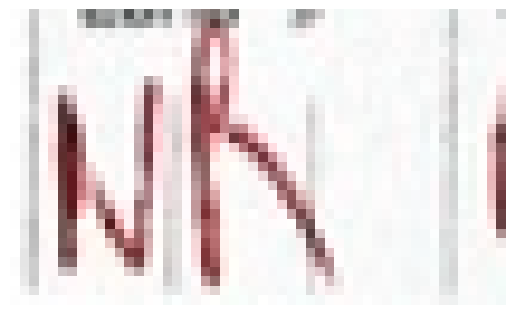

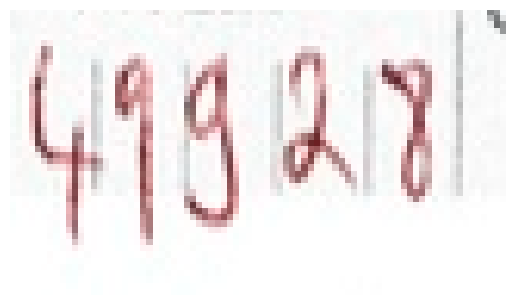

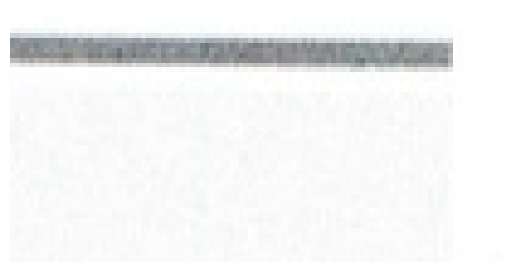

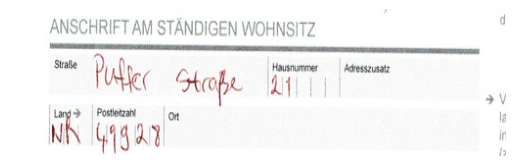

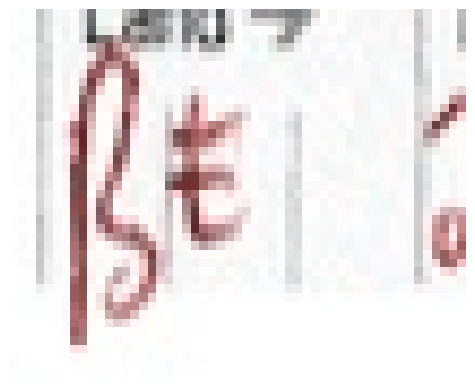

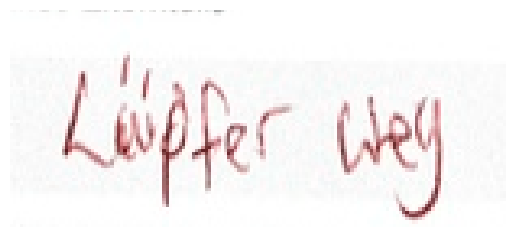

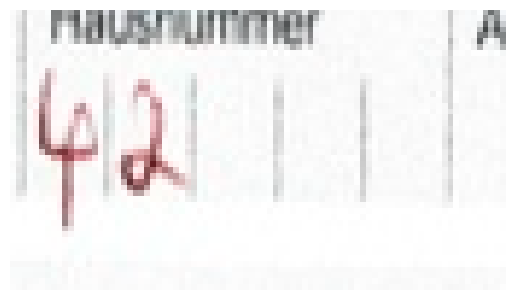

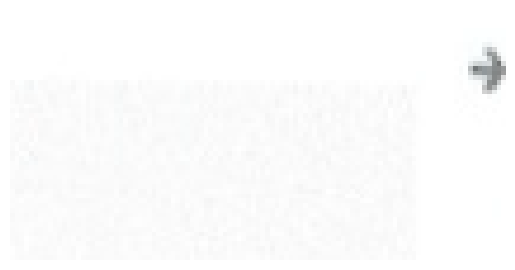

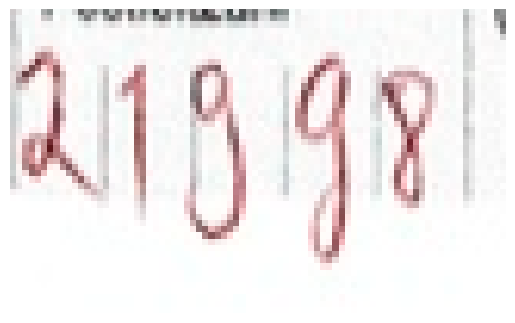

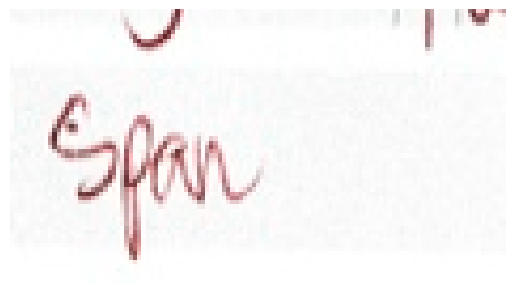

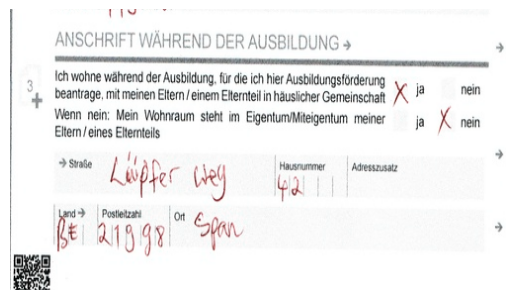

In [51]:
# Crop ROI
import cv2
from bounding_box.ressize import resize_imaged_without_expand_dim
from bounding_box.config import YOLO_WIDTH, YOLO_HEIGHT
def crop(xmin, ymin, xmax, ymax, image_path):
    image = cv2.imread(image_path)
    image = resize_imaged_without_expand_dim(image, YOLO_WIDTH, YOLO_HEIGHT)
    xmin = int(round(xmin))
    ymin = int(round(ymin))
    xmax = int(round(xmax))
    ymax = int(round(ymax))
    # width = int(round(width))
    # height = int(round(height))
    # rowBeg = y
    # rowEnd = y + height
    # columnBeg = x
    # columnEnd = x + width
    imgCropped = image[ymin:ymax, xmin:xmax]
    return imgCropped

import matplotlib.pyplot as plt
images_cropped = []
for b in sub_boxes:
    xmin, ymin, xmax, ymax = b
    imgCropped = crop(xmin, ymin, xmax, ymax, image_path)
    images_cropped.append(imgCropped)
    plt.axis("off")
    plt.imshow(imgCropped)
    plt.show()


## Handwriting Recognition

### Preprocess Image

In [52]:
import numpy as np
img_size=(preprocess.handwriting_img_w, preprocess.handwriting_img_h)
images = []
for image in images_cropped:
    image = np.mean(image, axis=2, keepdims=True)
    image = preprocess.distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    images.append(image)

### Plot Images

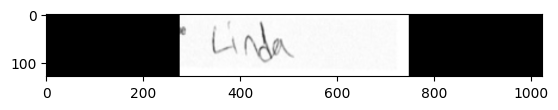

In [53]:
plot_image = images[9]
plot_image = np.transpose(plot_image, (1, 0, 2))
plot_image = np.flipud(plot_image)
plt.imshow(plot_image[:, :, 0],cmap='gray')

# Show the plot
plt.show()

### Handwriting Recognition Neural Network

In [54]:
from keras.models import load_model
import os
def load_model_and_weights():
    model_weight_path = "../models/model9v3_xl/model9v3_xl_weights.keras"
    model_path = "../models/model9v3_xl"
    print(model_path)
    if os.path.exists(model_path):
        print("Loading pre-trained model and weights...")
        model = load_model(model_path)
        model.load_weights(model_weight_path)
        print("Model and weights loaded successfully.")

        return model
    else:
        print("No pre-trained model or weights found.")
        return None

In [55]:
# Neural Network Handwriting
handwriting_model = load_model_and_weights()
prediction_model = keras.models.Model(handwriting_model.get_layer(name="image").input, handwriting_model.get_layer(name="dense2").output)
predicted_texts = []
# Prediction
for image in images:
    preds = prediction_model.predict(tf.expand_dims(image, axis=0))
    pred_texts = handwriting.decode_batch_predictions(preds)
    selected_pred_text = pred_texts[0]
    selected_pred_text = selected_pred_text.replace("|"," ")
    predicted_texts.append(selected_pred_text)

../models/model9v3_xl
Loading pre-trained model and weights...
Model and weights loaded successfully.
1/1 [==============================] - 0s 58ms/step


In [43]:
print(predicted_texts)

['Broren Horanule .', ' netion theoy.', ' Mkr .', 'nizziatpagitoset .', 'tohhabo bereis hunoremendatosranvaggeslell ta tor nen', 'siiin', "rifrilaton'.", 't"', ' Manener', 'hisaten.', 'Ruharn.', 'a fiton.', 'ii1a1l00s', 'y.', '"yr .', 'iziisi? .', 'a Libgen wey', 'iye   .', '.', '". ', '', 'FFziiiginior .', 'wk !', 'Hmtuge we.', 'tal "', '', 'ialtoz', 'Haribung', 'iiiizziii']


### Spell Checker

In [44]:
from spellchecker import SpellChecker

# spell = SpellChecker()

# Initialisierung des Spellcheckers für Deutsch
spell = SpellChecker(language='de')

# Hinzufügen von benutzerdefinierten Wörtern
# custom_words = ['Colin', 'asddf']
# spell.word_frequency.load_words(custom_words)

# Verwendung einer Datei von häufigen Wörtern oder Fachbegriffen
# with open('/data/custom_dictionary.txt') as f:
#     custom_words = f.read().splitlines()
# spell.word_frequency.load_words(custom_words)

output_text = []
for text in predicted_texts:
    words = [word for word in text.split(" ") if word != '']
    #Spellchecker
    corrected_text = ' '.join([spell.correction(word) if spell.correction(word) is not None else word for word in text.split()])
    output_text.append(corrected_text)
print(output_text)

['broken Horanule .', 'nation they', 'mir .', 'nizziatpagitoset .', 'tohhabo bereits hunoremendatosranvaggeslell ta tor nen', 'sein', "rifrilaton'.", 'tu', 'mannes', 'hisaten.', 'Ruharn.', 'a fiton.', 'ii1a1l00s', 'y', 'der .', 'iziisi? .', 'a liegen wer', 'bye .', '.', 'du', '', 'FFziiiginior .', 'wo !', 'Hmtuge wer', 'mal "', '', 'ialtoz', 'Haribung', 'iiiizziii']


# Plot Predicted Text and Image

In [45]:
def plot_evaluation(images, texts): 
    for i in range(16):
        pred_texts = texts[i]
        title = f"Prediction: {pred_texts}"
        plot_image = images[i]
        plot_image = np.transpose(plot_image, (1, 0, 2))
        plot_image = np.flipud(plot_image)
        plt.title(title)
        plt.imshow(plot_image[:, :, 0],cmap='gray')
        plt.show()
    


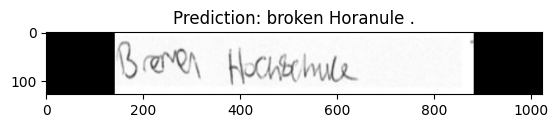

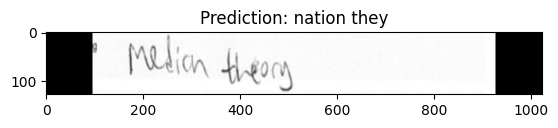

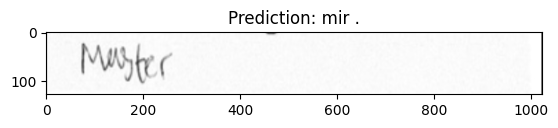

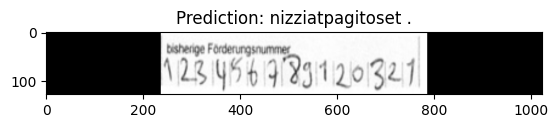

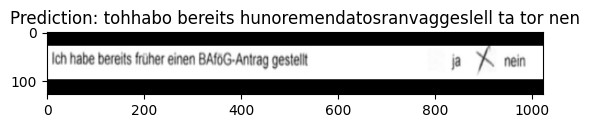

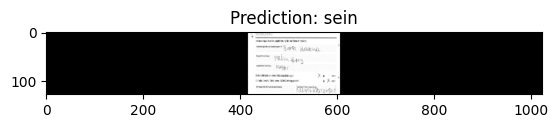

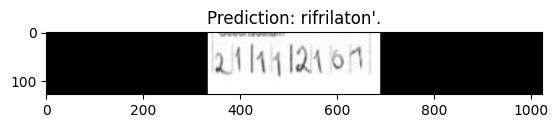

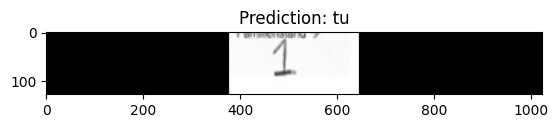

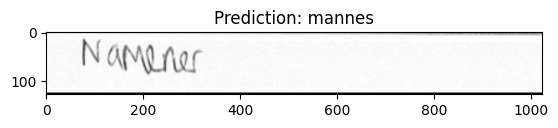

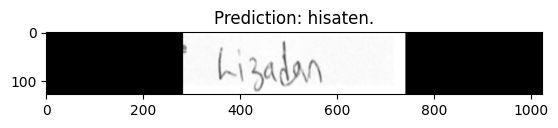

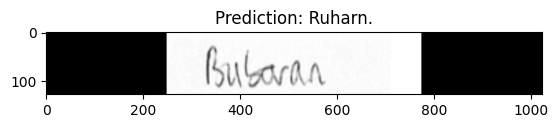

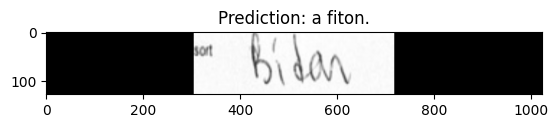

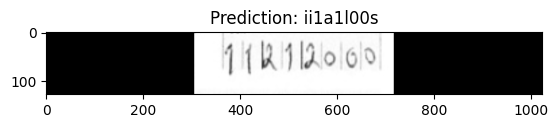

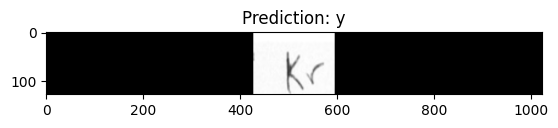

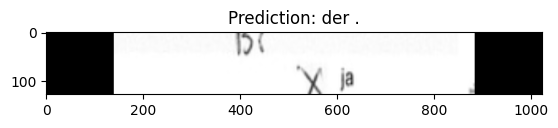

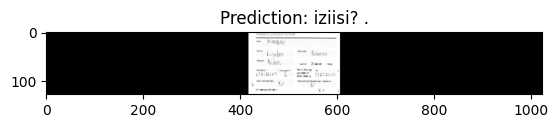

In [46]:
plot_evaluation(images, output_text)